In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_theme()

In [19]:
def load_data(file_path: str = '../data/trade_history.csv') -> pd.DataFrame:
    # Load the CSV into a DataFrame
    df = pd.read_csv(file_path)
    
    # Convert to datetime
    date_columns = ['Entry time', 'Exit time']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col])

    # Remove dollar sign and commas, convert to float for specified columns
    dollar_columns = ['Cum. net profit', 'Commission']
    for col in dollar_columns:
        df[col] = df[col].str.replace(r'[\$,]', '', regex=True).astype(float)
    
    # Convert percentage return to float
    df['Return'] = df['Return'].str.rstrip('%').astype(float)

    return df

df = load_data()
df.head()

,Trade number,Instrument,Account,Strategy,Market pos.,Qty,Entry price,Exit price,Entry time,Exit time,...,ETD,Bars,HWM,Drawdown,Return,Instrument Vol,Instrument Vol Floor,Annual Vol Target,Annual Realized Vol,Strat Scalar
0,1,NQ,Backtest,TrendVol,Long,4,5020.50,5018.50,2017-01-10 02:54:00,2017-01-10 09:40:00,...,$782.72,15,"$100,000.00",-0.18%,-0.18,0.000819,0.002,0.2,0.166956,0.778614
1,2,NQ,Backtest,TrendVol,Long,3,5028.50,5036.25,2017-01-10 10:56:00,2017-01-10 13:51:00,...,$662.04,7,"$100,265.24",0.00%,0.45,0.000775,0.002,0.2,0.178878,0.651149
2,3,NQ,Backtest,TrendVol,Long,3,5047.50,5041.50,2017-01-11 16:03:00,2017-01-11 19:14:00,...,$422.04,5,"$100,265.24",-0.38%,-0.38,0.000754,0.002,0.2,0.155804,0.632381
3,4,NQ,Backtest,TrendVol,Long,4,5048.75,5053.50,2017-01-13 09:34:00,2017-01-13 12:28:00,...,$802.72,6,"$100,265.24",-0.02%,0.36,0.000751,0.002,0.2,0.118007,1.236208
4,5,NQ,Backtest,TrendVol,Long,4,5054.50,5048.25,2017-01-18 10:05:00,2017-01-18 10:09:00,...,$522.72,1,"$100,265.24",-0.54%,-0.52,0.000757,0.002,0.2,0.098349,1.859764


In [20]:
# Group daily aggregation
daily = df.groupby(df['Entry time'].dt.date).agg({
    'Return': 'sum',
    'Cum. net profit': 'last',
    'Entry time': 'last'
}).reset_index(drop=True)

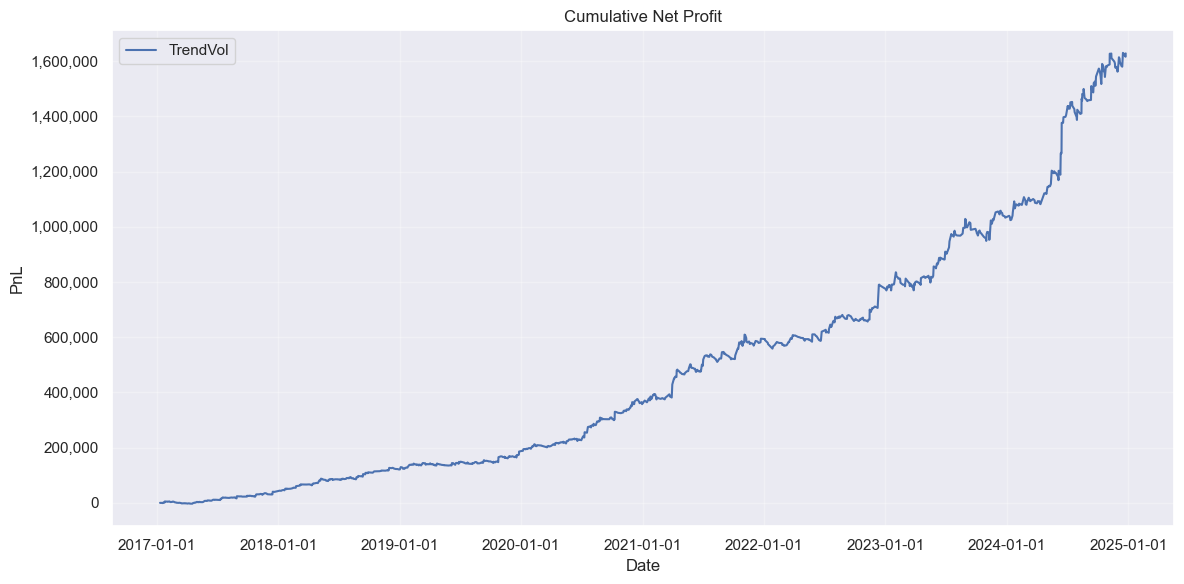

Start date: 2017-01-10
End date: 2024-12-26
Net Profit: $1,628,023.36
Total Commission: $46,729.36


In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(daily['Entry time'], daily['Cum. net profit'], label='TrendVol')

def millions_formatter(x, pos):
   return f'{x:,.0f}'

ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(AutoDateLocator())
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.title('Cumulative Net Profit')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Start date: {df['Entry time'].min().strftime('%Y-%m-%d')}")
print(f"End date: {df['Exit time'].max().strftime('%Y-%m-%d')}")
print(f"Net Profit: ${df['Cum. net profit'].iloc[-1] - df['Cum. net profit'].iloc[0]:,.2f}")
print(f"Total Commission: ${df['Commission'].sum():,.2f}")

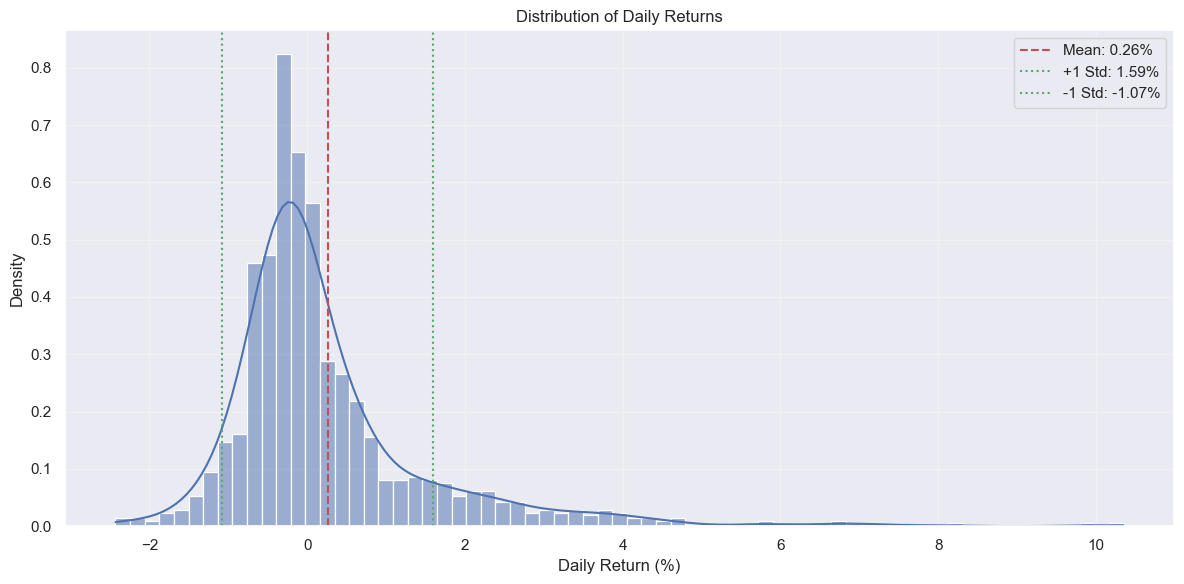

Mean Daily Return: 0.26%
Daily Volatility: 1.33%
Annualized Volatility: 21.22%
Sharpe Ratio: 3.09


In [22]:
plt.figure(figsize=(12, 6))

sns.histplot(data=daily, x='Return', kde=True, stat='density')

mean_return = daily['Return'].mean()
std_return = daily['Return'].std()

plt.axvline(mean_return, color='r', linestyle='--', label=f'Mean: {mean_return:.2f}%')
plt.axvline(mean_return + std_return, color='g', linestyle=':', label=f'+1 Std: {(mean_return + std_return):.2f}%')
plt.axvline(mean_return - std_return, color='g', linestyle=':', label=f'-1 Std: {(mean_return - std_return):.2f}%')

plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Mean Daily Return: {mean_return:.2f}%")
print(f"Daily Volatility: {std_return:.2f}%")
print(f"Annualized Volatility: {std_return * np.sqrt(253):.2f}%")
print(f"Sharpe Ratio: {(mean_return / std_return) * np.sqrt(253):.2f}")

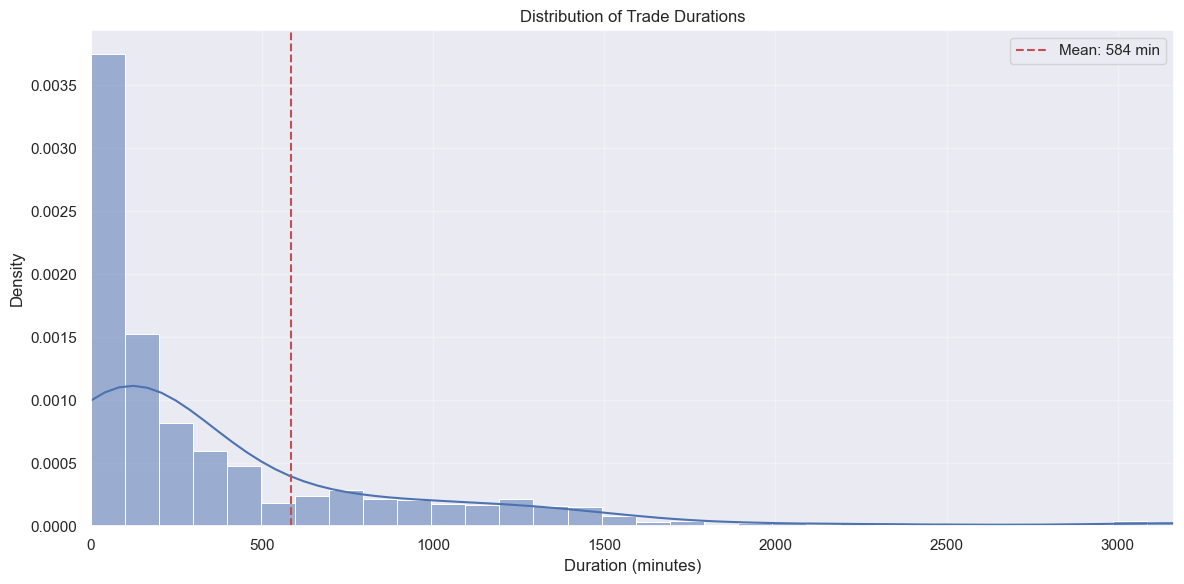

Mean Hold Time: 584 minutes


In [23]:
plt.figure(figsize=(12, 6))

df['Duration_Minutes'] = (df['Exit time'] - df['Entry time']).dt.total_seconds() / 60

sns.histplot(data=df['Duration_Minutes'], kde=True, stat='density')

mean_duration = df['Duration_Minutes'].mean()

plt.axvline(mean_duration, color='r', linestyle='--', label=f'Mean: {mean_duration:.0f} min')
plt.xlim(0, df['Duration_Minutes'].quantile(0.95))

plt.title('Distribution of Trade Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Mean Hold Time: {mean_duration:.0f} minutes")

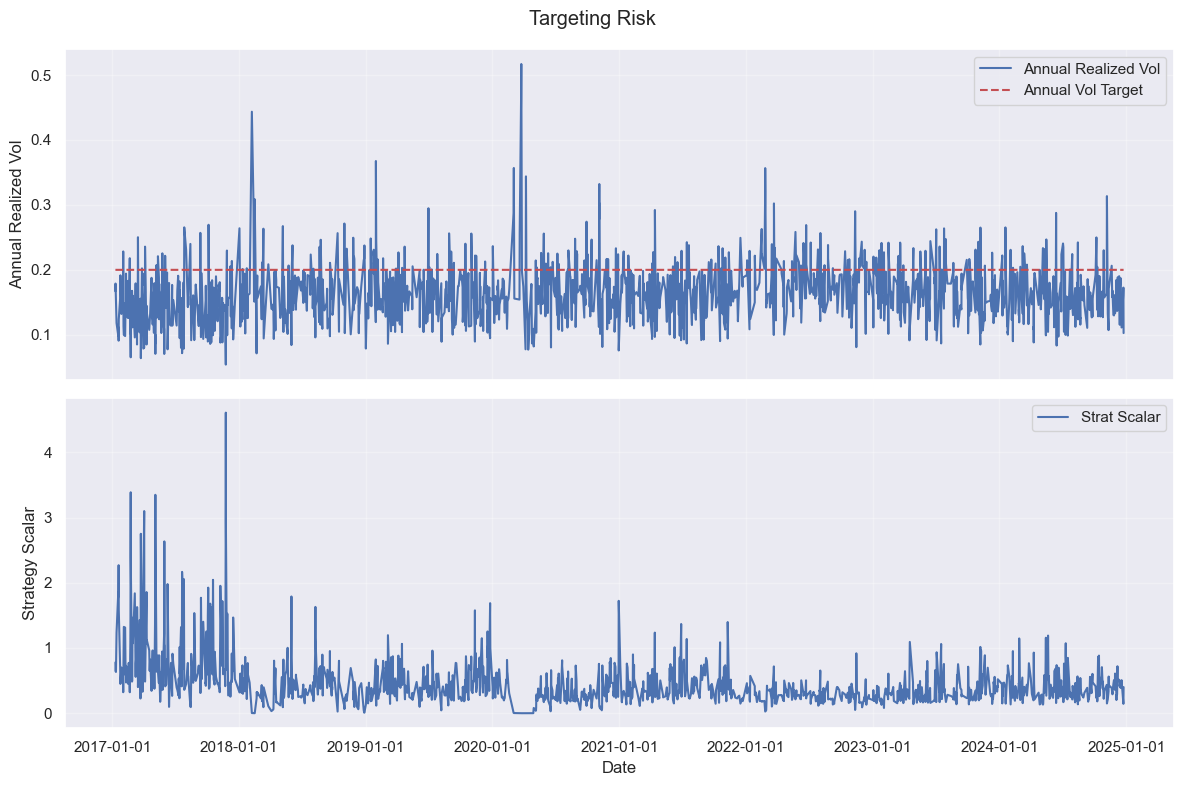

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

fig.suptitle('Targeting Risk')

# Top plot - Annual Realized Vol
ax1.plot(df['Entry time'], df['Annual Realized Vol'], label='Annual Realized Vol')
ax1.plot(df['Entry time'], df['Annual Vol Target'], label='Annual Vol Target', color='r', linestyle='--')
ax1.set_ylabel('Annual Realized Vol')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Bottom plot - Strategy Scalar
ax2.plot(df['Entry time'], df['Strat Scalar'], label='Strat Scalar')
ax2.set_ylabel('Strategy Scalar')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)
ax2.legend()

ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(AutoDateLocator())

plt.tight_layout()
plt.show()

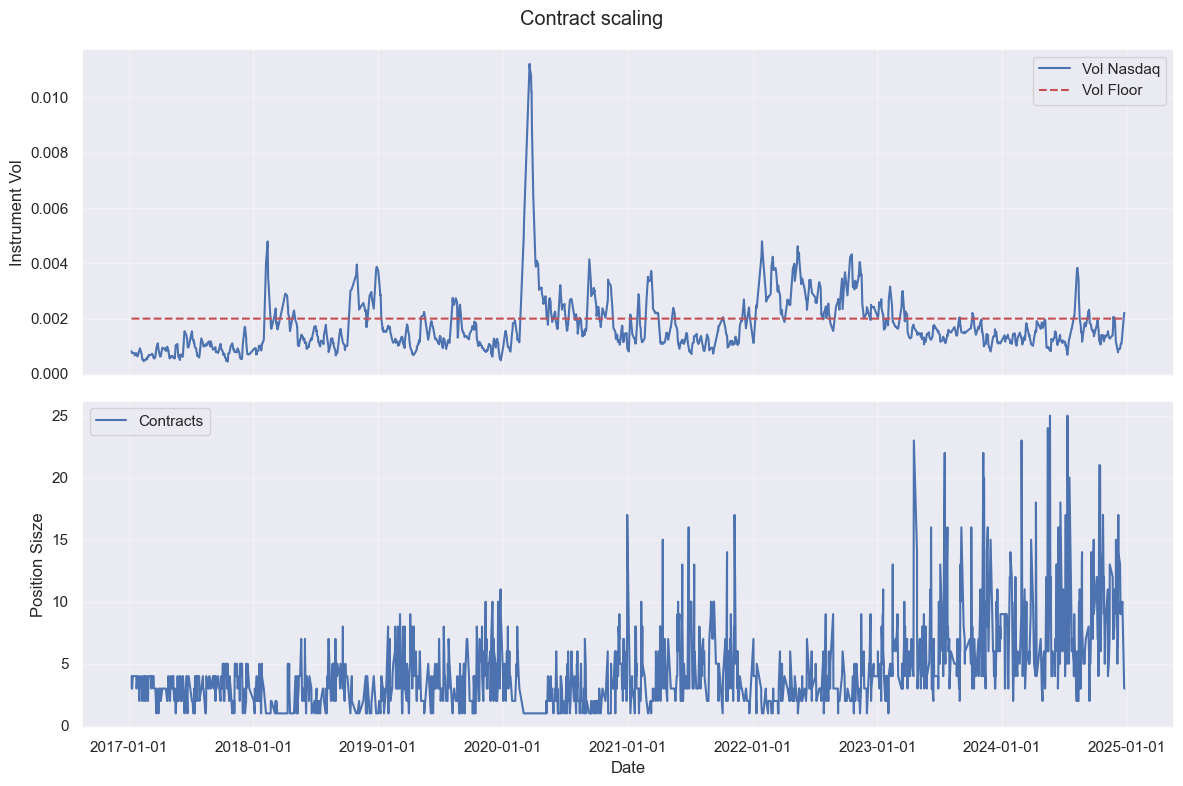

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

fig.suptitle('Contract scaling')

# Top plot - Instrument Volatility (NQ)
ax1.plot(df['Entry time'], df['Instrument Vol'], label='Vol Nasdaq')
ax1.plot(df['Entry time'], df['Instrument Vol Floor'], label='Vol Floor', color='r', linestyle='--')
ax1.set_ylabel('Instrument Vol')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Bottom plot - Position Size
ax2.plot(df['Entry time'], df['Qty'], label='Contracts')
ax2.set_ylabel('Position Sisze')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)
ax2.legend()

ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(AutoDateLocator())

plt.tight_layout()
plt.show()